# **PRÁCTICA 3 OPTICA III**

**JULIO DAVID RUIZ MENDOZA 23958366W**

---

In [9]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

#Funcion extents
def extents(f):
    delta = f[1] - f[0]
    return [f[0] - delta/2, f[-1] +delta/2]

%matplotlib inline

# **Cálculo numérico de la propagación. Aplicación a la propagación de un vórtice óptico y de un haz de Bessel.**


**1) Implementar la operación de propagación en la aproximación de Fresnel de lastres formas siguientes. Utilizar una onda plana con $\lambda = 500 nm$ limitada por una a apertura circular de 10 mm de diámetro en $z=0$.**

**a) Utilizando el espectro angular (función de transferencia correspondiente a la
propagación una distancia $z$).**

$$ H(f_x, f_y) = e^{ikz}e^{-i\pi\lambda z(f_x^2 + f_y^2)} $$

**Este método involucra el cálculo de dos transformadas de Fourier.**

$$ u_2(x_0,y_0) = FT^{-1} [FT[u_1(x_1,y_1)]H(f_x,f_y)] $$

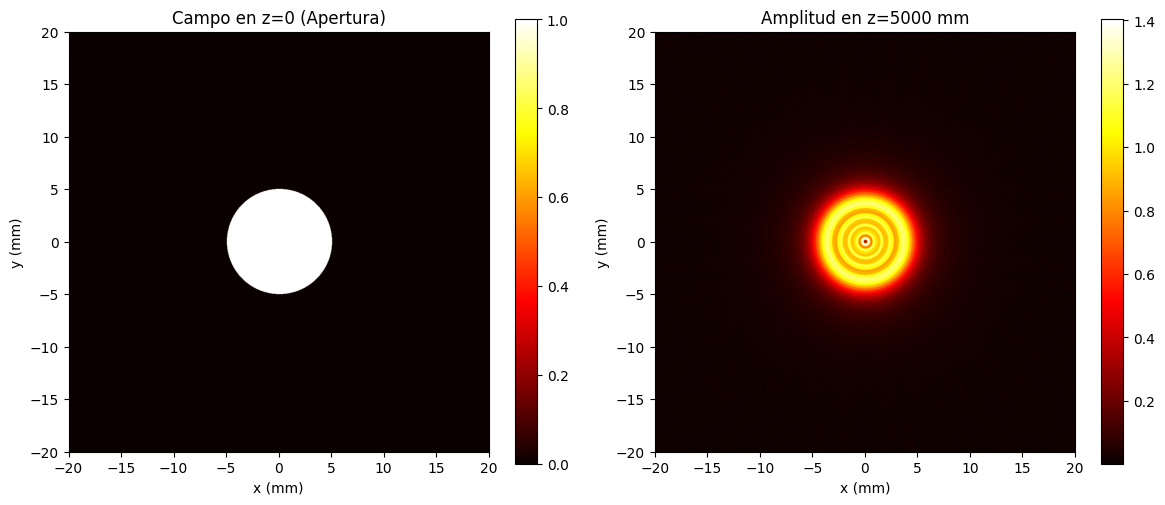

In [10]:
# 1. Definición de parámetros físicos
lam_0 = 500e-6      # 500 nm en mm
k = 2*np.pi/lam_0   # numero de onda
a = 5.0             # radio de apertura en mm
z = 5e3          # distancia en mm
L = 40.0            # tamaño de la ventana en mm
N = 1024            # puntos de muestreo

# 2. Mallado Espacial
dx = L / N
x = np.linspace(-L/2, L/2, N)
y = np.linspace(-L/2, L/2, N)
X, Y = np.meshgrid(x, y)

# 3. Generación de la apertura (Onda plana limitada por círculo)
# Usamos una máscara, más eficiente que bucle for
R = np.sqrt(X**2 + Y**2)
u0 = np.zeros_like(R)
u0[R <= a] = 1.0  # Onda plana amplitud 1 dentro del radio

# 4. Mallado de Frecuencias
# Usamos fftfreq que genera las frecuencias en el orden correcto para la FFT
fx = np.fft.fftfreq(N, d=dx)
fy = np.fft.fftfreq(N, d=dx)
FX, FY = np.meshgrid(fx, fy)

# 5. Función de Transferencia (Kernel de Fresnel)
# El enunciado pide: H = exp(ikz) * exp(-i * pi * lambda * z * (fx^2 + fy^2))
H = np.exp(1j * k * z) * np.exp(-1j * np.pi * lam_0 * z * (FX**2 + FY**2))

# 6. Propagación
# Algoritmo: FFT -> Multiplicar por H -> IFFT
U0_hat = np.fft.fft2(u0) # Espectro
U_z_hat = U0_hat * H     # Propagación en frecuencia
U_z = np.fft.ifft2(U_z_hat) # Vuelta al espacio

# 7. Graficar
plt.figure(figsize=(12, 5))

# Plano z=0
plt.subplot(1, 2, 1)
plt.imshow(np.abs(u0), extent=[-L/2, L/2, -L/2, L/2], cmap='hot')
plt.title("Campo en z=0 (Apertura)")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

# Plano z propagada
plt.subplot(1, 2, 2)
# Mostramos la intensidad (amplitud al cuadrado) o magnitud
plt.imshow(np.abs(U_z), extent=[-L/2, L/2, -L/2, L/2], cmap='hot')
plt.title(f"Amplitud en z={int(z)} mm")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()

plt.tight_layout()
plt.show()

**b) Como una integral de convolución. En este caso son necesarias tres
transformadas de Fourier**

$$u_2(x,y) = u_1(x,y)*h(x,y) = FT^{-1}[FT[u_1(x,y)]FT[h(x,y)]] $$

**donde**

$$ h(x,y;z) = \frac{ e^{i \ k \ z} }{ i \lambda z} e^{\frac{i \pi}{\lambda z} (x^2 +y^2) }$$

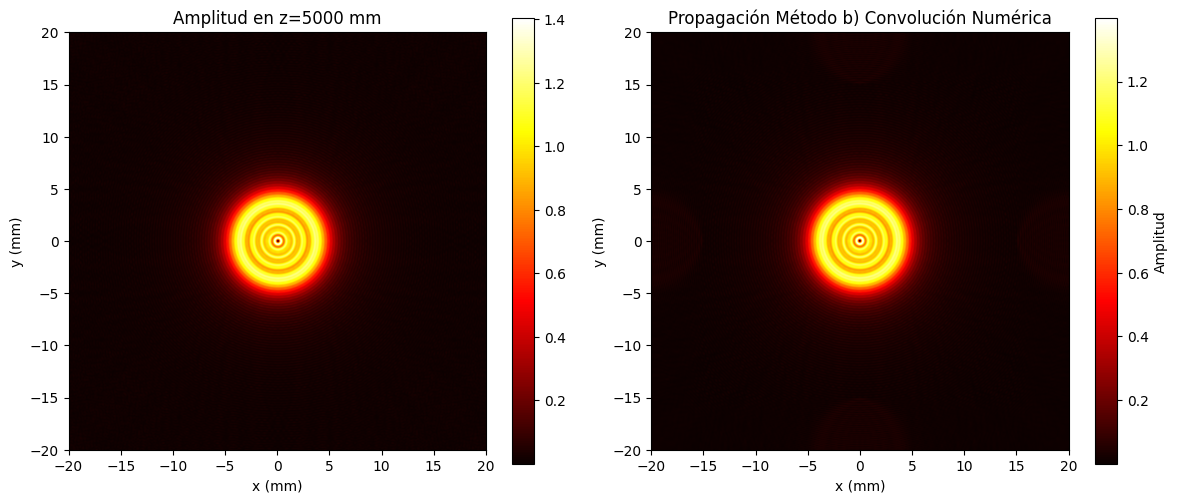

In [11]:
# h(x,y) definida analíticamente
factor_fase = 1j * k * z
factor_amplitud = 1 / (1j * lam_0 * z)
h = factor_amplitud * np.exp(factor_fase) * np.exp(1j * np.pi * (X**2 + Y**2) / (lam_0 * z))

# Aplicación del Teorema de Convolución

# Paso A: Transformada de Fourier de la entrada
U0_spectrum = np.fft.fft2(u0)

# Paso B: Transformada de Fourier de la Respuesta al Impulso (H_numeric)
H_spectrum = np.fft.fft2(np.fft.ifftshift(h))

# Factor de escala (dx * dy) para convertir la suma discreta en integral continua
H_spectrum = H_spectrum * (dx * dx)

# Paso C: Multiplicación en frecuencia
U_z_spectrum = U0_spectrum * H_spectrum

# Paso D: Transformada Inversa
U_z_b = np.fft.ifft2(U_z_spectrum)

# Representación Gráfica
plt.figure(figsize=(12, 5))

# Grafica apartado a
plt.subplot(1, 2, 1)
plt.imshow(np.abs(U_z), extent=[-L/2, L/2, -L/2, L/2], cmap='hot')
plt.title(f"Amplitud en z={int(z)} mm")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()


# Apartado b
plt.subplot(1, 2, 2)
plt.imshow(np.abs(U_z_b), extent=[-L/2, L/2, -L/2, L/2], cmap='hot')
plt.title("Propagación Método b) Convolución Numérica")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar(label="Amplitud")


plt.tight_layout()
plt.show()

**c)  Directamente, usando una única transformada de Fourier utilizando la expresión**

$$u_2(x_0,y_0) = \frac{1}{i \lambda z } e^{ \frac{i \  k}{2 z} (x_0^2 + y_0^2)  } FT[ e^{ \frac{i \ k}{2 z} (x_1^2 + y_1^2)  } u_1(x_1,y_1) ] $$

Tamaño ventana entrada: 40.0 mm
Tamaño ventana salida:  63.94 mm (El mallado ha cambiado)


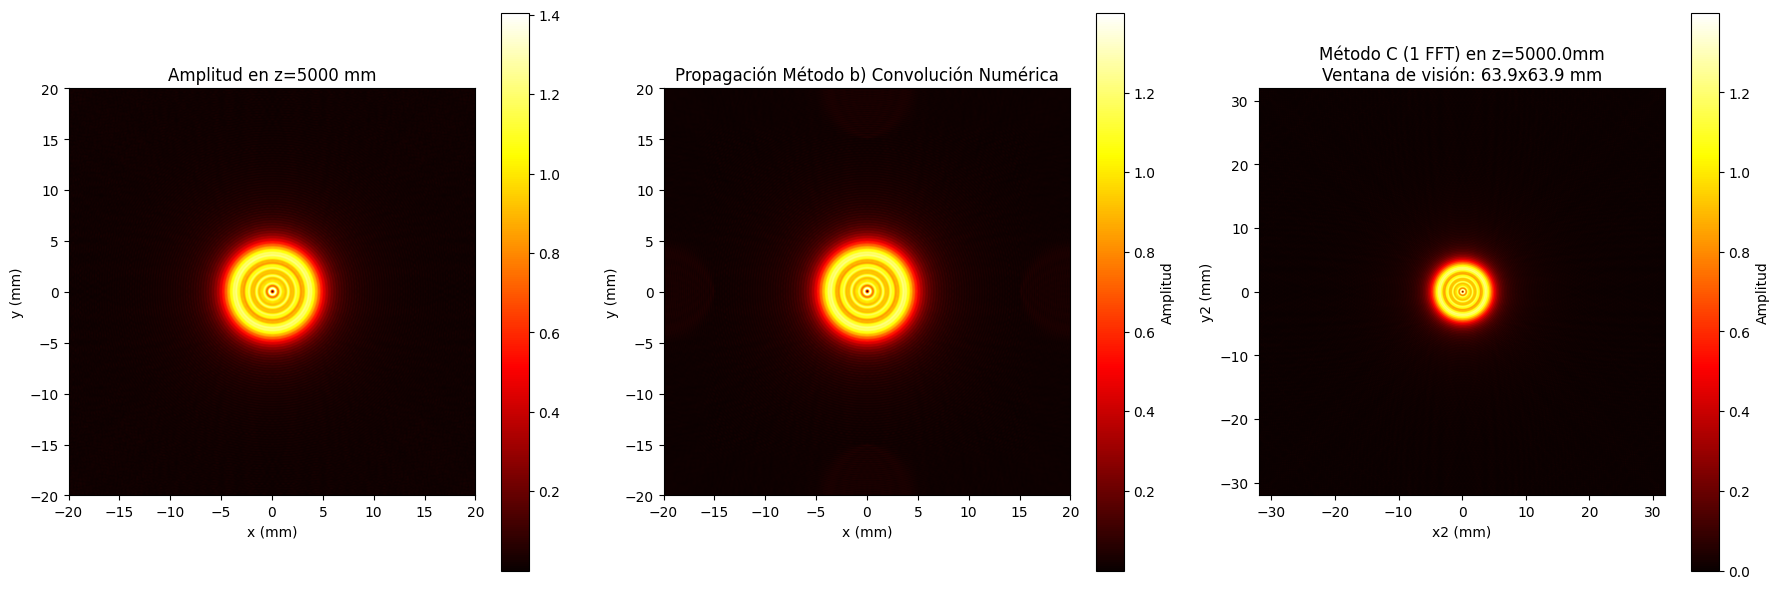

In [12]:
L1 = 40.0           # Tamaño ventana entrada (mm)
N = 1024
dx1 = L1 / N

# Coordenadas de entrada (x1, y1)
x1 = np.linspace(-L1/2, L1/2, N)
y1 = np.linspace(-L1/2, L1/2, N)
X1, Y1 = np.meshgrid(x1, y1)

# Implementación del Método C (Single FFT)

# Fase cuadrática PREVIA a la transformada (dentro de la integral)
fase_in = np.exp(1j * k / (2*z) * (X1**2 + Y1**2))

# Calcular la Transformada de Fourier
# u0 * fase_in es lo que transformamos.
# Multiplicamos por dx1*dx1 para simular la integral física (escalado)
termino_a_transformar = u0 * fase_in
FT_resultado = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(termino_a_transformar))) * (dx1**2)

# Recalcular el Mallado de Salida
# En este método, las coordenadas de salida x2 dependen de las frecuencias fx
# Relación: x2 = lambda * z * fx

# Rango de frecuencias de la FFT: de -1/(2*dx1) a 1/(2*dx1)
fx = np.fft.fftshift(np.fft.fftfreq(N, d=dx1))
x2 = lam_0 * z * fx # Nuevas coordenadas espaciales en z
X2, Y2 = np.meshgrid(x2, x2)

# El tamaño físico de la nueva ventana es:
L2 = np.max(x2) - np.min(x2)
print(f"Tamaño ventana entrada: {L1} mm")
print(f"Tamaño ventana salida:  {L2:.2f} mm (El mallado ha cambiado)")

# Fase cuadrática POSTERIOR (fuera de la integral)
# pre_factor = (1 / i*lam*z) * exp(ikz) * exp(i * k / (2z) * (x2^2 + y2^2))
factor_constante = (np.exp(1j * k * z)) / (1j * lam_0 * z)
fase_out = np.exp(1j * k / (2*z) * (X2**2 + Y2**2))

# Campo final
Uz_c = factor_constante * fase_out * FT_resultado

# Representación Gráfica
plt.figure(figsize=(18, 6))

# Grafica apartado a
plt.subplot(1, 3, 1)
plt.imshow(np.abs(U_z), extent=[-L/2, L/2, -L/2, L/2], cmap='hot')
plt.title(f"Amplitud en z={int(z)} mm")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar()


# Apartado b
plt.subplot(1, 3, 2)
plt.imshow(np.abs(U_z_b), extent=[-L/2, L/2, -L/2, L/2], cmap='hot')
plt.title("Propagación Método b) Convolución Numérica")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar(label="Amplitud")

# Apartado c
# Nota el extent: Usamos x2, no x1.
plt.subplot(1, 3, 3)
plt.imshow(np.abs(Uz_c), extent=[x2.min(), x2.max(), x2.min(), x2.max()], cmap='hot')
plt.title(f"Método C (1 FFT) en z={z}mm\nVentana de visión: {L2:.1f}x{L2:.1f} mm")
plt.xlabel("x2 (mm)")
plt.ylabel("y2 (mm)")
plt.colorbar(label="Amplitud")


plt.tight_layout()
plt.show()


  
**2)Comparar los resultados anteriores con el calculo sin utilizar la aproximación de
Fresnel, es decir, considerando la función impulso-respuesta como**

$$ h(x,y;z) = \frac{1}{i \lambda z} e^{\frac{i \ 2 \pi}{\lambda} \sqrt{x^2 +y^2 + z^2}} $$

**correspondiente a la función de transferencia**

$$  $$

$$  \ \ k_x^2+k_y^2 < k^2 $$

$$ H(k_x,k_y;z)= \left\{ \begin{array}{lcc}
             e^{i z  \sqrt{k^2 -k_x^2- k_y^2} } &   si  & k_x^2+k_y^2 < k^2 \\
             \\  0 \\
             \\
             \end{array}
   \right. $$

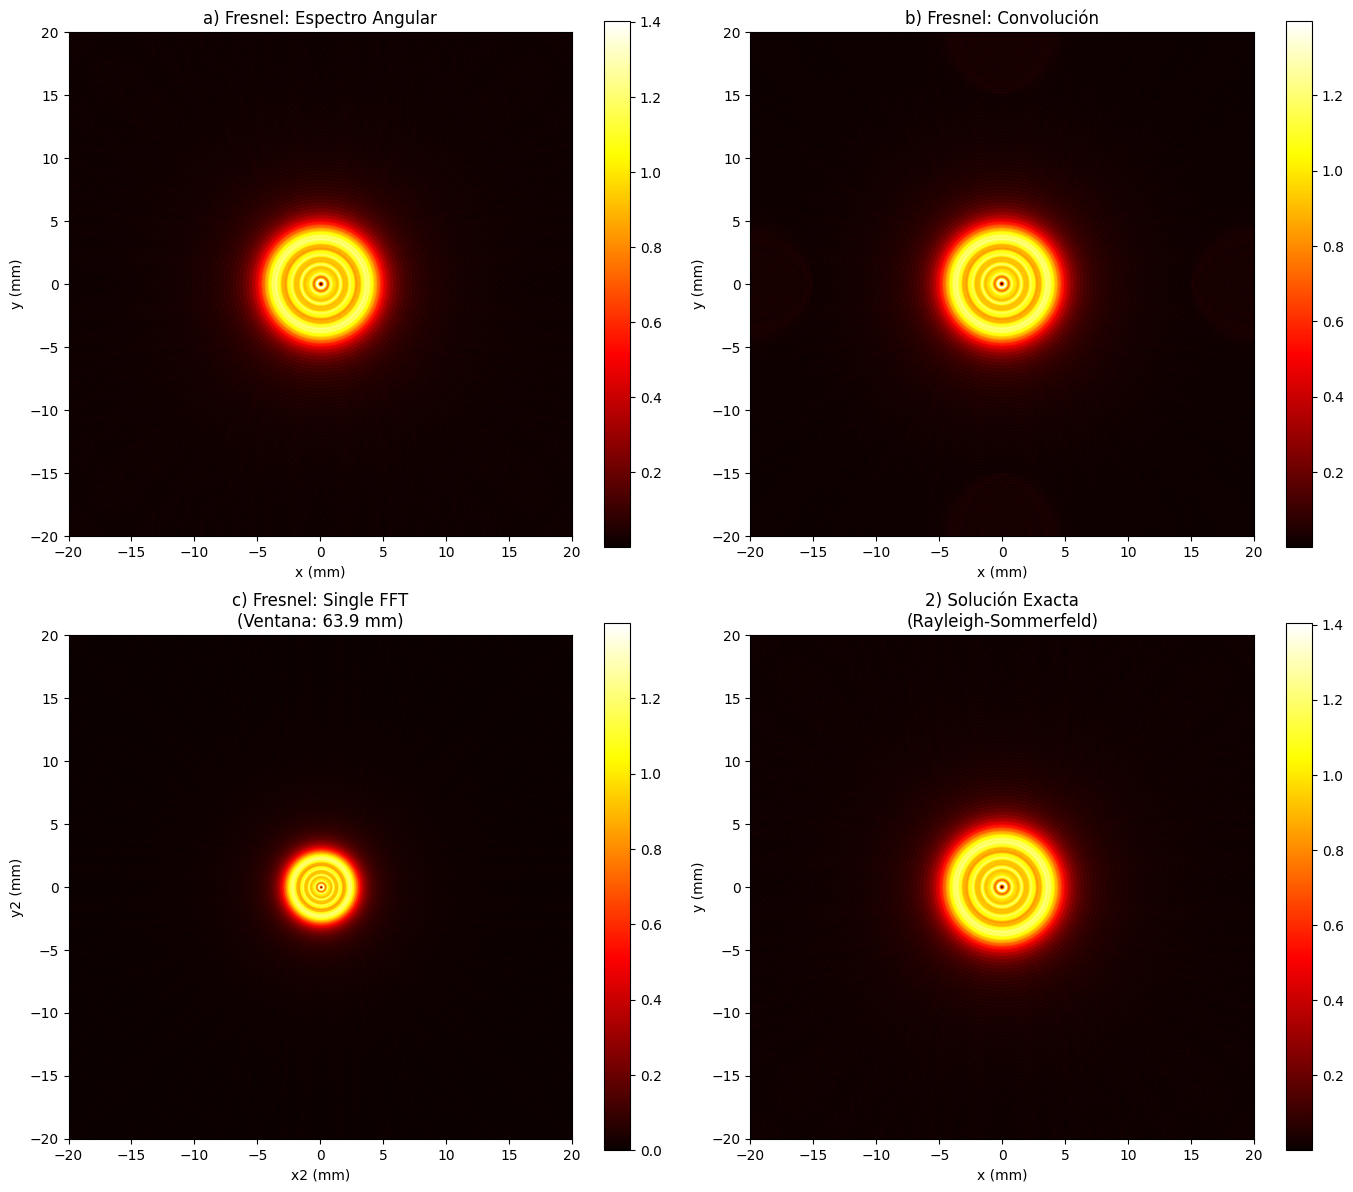

In [13]:
# H(fx, fy) = exp(i * 2*pi * z * sqrt(1/lambda^2 - fx^2 - fy^2))
# Recuperamos las frecuencias del mallado original (N, dx)
fx = np.fft.fftfreq(N, d=dx)
fy = np.fft.fftfreq(N, d=dx)
FX, FY = np.meshgrid(fx, fy)

# Cálculo del argumento de la raíz
# Condición de propagación: (1/lambda)^2 > fx^2 + fy^2
sq_arg = (1/lam_0)**2 - (FX**2 + FY**2)

# Inicializamos la función de transferencia
H_exacta = np.zeros(sq_arg.shape, dtype=complex)

# Máscara para ondas que se propagan (evanescentes se quedan en 0)
mask = sq_arg >= 0
H_exacta[mask] = np.exp(1j * 2 * np.pi * z * np.sqrt(sq_arg[mask]))

# Si no tienes U0_hat calculado de antes, lo calculamos ahora:
if 'U0_hat' not in locals():
    U0_hat = np.fft.fft2(u0)

# Propagación Exacta
Uz_exacto = np.fft.ifft2(U0_hat * H_exacta)


# REPRESENTACIÓN GRÁFICA
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# Apartado a)
im1 = ax[0, 0].imshow(np.abs(U_z), extent=[-L/2, L/2, -L/2, L/2], cmap='hot')
ax[0, 0].set_title(f"a) Fresnel: Espectro Angular")
ax[0, 0].set_xlabel("x (mm)")
ax[0, 0].set_ylabel("y (mm)")
fig.colorbar(im1, ax=ax[0, 0])

# Apartado b)
im2 = ax[0, 1].imshow(np.abs(U_z_b), extent=[-L/2, L/2, -L/2, L/2], cmap='hot')
ax[0, 1].set_title("b) Fresnel: Convolución")
ax[0, 1].set_xlabel("x (mm)")
ax[0, 1].set_ylabel("y (mm)")
fig.colorbar(im2, ax=ax[0, 1])

#  Apartado c)

im3 = ax[1, 0].imshow(np.abs(Uz_c), extent=[-L/2, L/2, -L/2, L/2], cmap='hot')
ax[1, 0].set_title(f"c) Fresnel: Single FFT\n(Ventana: {L2:.1f} mm)")
ax[1, 0].set_xlabel("x2 (mm)")
ax[1, 0].set_ylabel("y2 (mm)")
fig.colorbar(im3, ax=ax[1, 0])

# Ejercicio 2 (Exacta)
im4 = ax[1, 1].imshow(np.abs(Uz_exacto), extent=[-L/2, L/2, -L/2, L/2], cmap='hot')
ax[1, 1].set_title("2) Solución Exacta\n(Rayleigh-Sommerfeld)")
ax[1, 1].set_xlabel("x (mm)")
ax[1, 1].set_ylabel("y (mm)")
fig.colorbar(im4, ax=ax[1, 1])

plt.tight_layout()
plt.show()

**3.Utilizar el código escrito en el apartado anterior para calcular la distribución de
intensidad en el espacio de una onda que se propaga en la dirección $z$ con una
singularidad (vórtice óptico)
$$ u_1(\phi_1) = u_0 e^{i \ n \  \phi_1 -i \ k \ z} $$
donde $ \phi_1 $ es el ángulo polar y $n$ es la carga topológica, después de atravesar la
apertura. Representar gráficamente la distribución de intensidad en el plano axial$(x,y)$
.**
<img src ="Vortice.png">

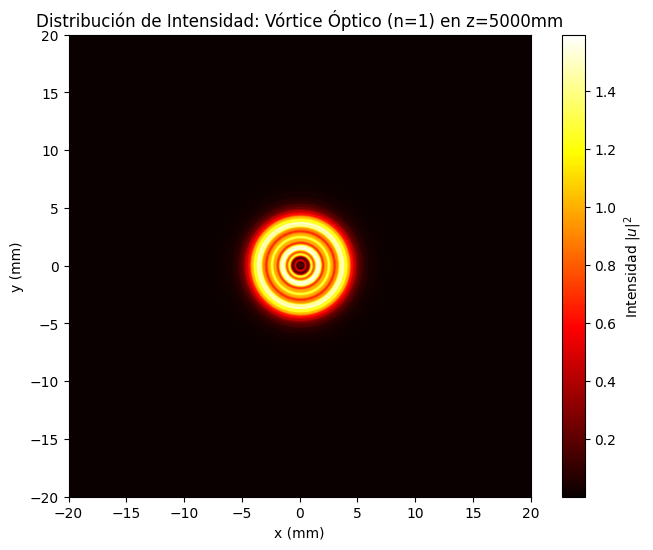

In [14]:
phi = np.arctan2(Y, X)
n = 1


# Definición del campo de entrada:
# u_in = Apertura(circ) * Fase_Espiral(exp(inφ))
# Nota: Omitimos el término -ikz aquí porque definimos el campo en z=0.
# La propagación se encarga de añadir la fase correspondiente a z.
u_vortex_in = u0 * np.exp(1j * n * phi)

# Propagación (Usando la Solución Exacta H calculada antes)
# Transformada del campo vórtice
U_vortex_hat = np.fft.fft2(u_vortex_in)

# Propagación
U_vortex_z = np.fft.ifft2(U_vortex_hat * H_exacta)

# Intensidad (Magnitud al cuadrado)
I_vortex = np.abs(U_vortex_z)**2

# Representación Gráfica
plt.figure(figsize=(8, 6))

plt.imshow(I_vortex, extent=[-L/2, L/2, -L/2, L/2], cmap='hot')
plt.title(f"Distribución de Intensidad: Vórtice Óptico (n={n}) en z={int(z)}mm")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar(label="Intensidad $|u|^2$")

# Añadimos un zoom visual si el campo es pequeño comparado con L
# plt.xlim(-10, 10)
# plt.ylim(-10, 10)

plt.show()

**4.Estudiar la distribución de intensidad en el espacio generada por un prisma de revolución (axicón) de la Fig.2 (https://www.edmundoptics.com/knowledge-center/application-notes/lasers/an-in-depth-look-at-axicons/) de radio $R$, ángulo de apex $A$ e índice de refracción $n$ = 1.5, iluminado con una onda plana de amplitud unidad. De acuerdo con la geometría ilustrada, inmediatamente después del componente óptico, la amplitud de campo es:
$$ u_{1} (\phi _{1}) = u_{0} \exp(i k n \Delta (r)) $$
donde $\Delta (r)$ es el espesor,
$$ \Delta (r) = A - \frac{A}{R}r $$**

<img src = "Axicon.png">

Espesor máximo (A_axicon): 0.0500 mm
Ángulo simulado: 0.57°
Profundidad de Foco (DOF) teórica: 1000.0 mm
Diámetro del anillo teórico en z=3000.0: 30.00 mm


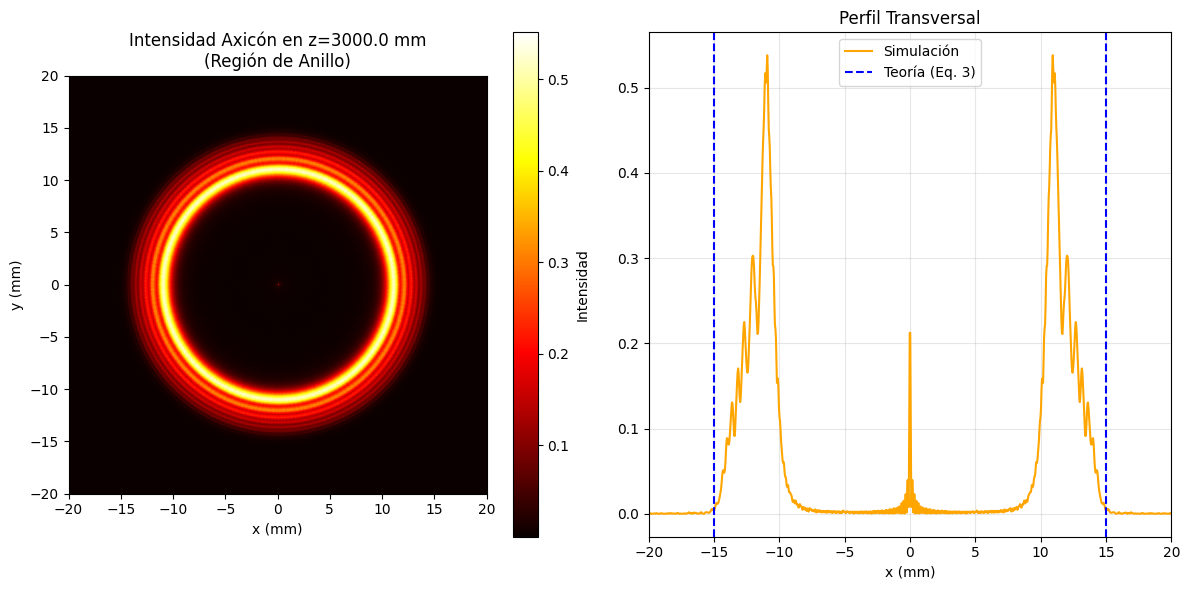

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# CONFIGURACIÓN FÍSICA

lam_0 = 500e-6      # 500 nm en mm
k = 2 * np.pi / lam_0
n_ref = 1.5         # Índice de refracción (Vidrio)
R_axicon = 5.0      # Radio del axicón (mm) - Apertura
A_axicon = 0.05     # Altura axicon (mm)
L = 40.0            # Tamaño de la ventana (mm)
N = 1024            # Puntos de muestreo
dx = L / N
z = 3e3          # Distancia de la pantalla (mm). Como z > DOF, veremos el ANILLO (Figs 2-3 del texto)

# Mallado espacial
x = np.linspace(-L/2, L/2, N)
y = np.linspace(-L/2, L/2, N)
X, Y = np.meshgrid(x, y)
r = np.sqrt(X**2 + Y**2)
# Mallado de frecuencias
fx = np.fft.fftfreq(N, d=dx)
fy = np.fft.fftfreq(N, d=dx)
FX, FY = np.meshgrid(fx, fy)



# Calculamos el ángulo a partir de A_axicon
# Según tu texto: Delta(r) = A - (A/R)*r
# Geometría del cono: A = R * tan(alpha)
alpha_rad = np.arctan(A_axicon / R_axicon)
alpha_deg = np.rad2deg(alpha_rad)

print(f"Espesor máximo (A_axicon): {A_axicon:.4f} mm")
print(f"Ángulo simulado: {alpha_deg:.2f}°")


# El texto dice que el DOF approx R / ((n-1)*alpha).
DOF = R_axicon / ((n_ref - 1) * alpha_rad)
print(f"Profundidad de Foco (DOF) teórica: {DOF:.1f} mm")



# GENERACIÓN DEL CAMPO EN Z=0
# Máscara de apertura (el axicón tiene radio finito R)
u0 = np.zeros_like(r)
u0[r <= R_axicon] = 1.0

# Función de Espesor Delta(r) = A - (A/R)r
Delta_r = A_axicon - (A_axicon / R_axicon) * r
Delta_r[r > R_axicon] = 0 # El espesor es 0 fuera del axicón

# FASE DE TRANSMISIÓN
# La fórmula física para una lámina delgada es t = exp(i * k * (n - 1) * Delta)
# (n-1) representa la diferencia de camino óptico entre vidrio y aire.
u_axicon = u0 * np.exp(1j * k * (n_ref - 1) * Delta_r)

# PROPAGACIÓN EXACTA (Espectro Angular)
# Función de Transferencia Exacta
sq_arg = (1/lam_0)**2 - (FX**2 + FY**2)
H_exacta = np.zeros(sq_arg.shape, dtype=complex)
mask_prop = sq_arg >= 0
H_exacta[mask_prop] = np.exp(1j * 2 * np.pi * z * np.sqrt(sq_arg[mask_prop]))

# Cálculo FFT
U_in_hat = np.fft.fft2(u_axicon)
Uz_axicon = np.fft.ifft2(U_in_hat * H_exacta)

# Intensidad
I_axicon = np.abs(Uz_axicon)**2

# CÁLCULO TEÓRICO DEL DIÁMETRO DEL ANILLO
# Ecuación (3) aproximada del texto: dr = 2 * L * tan((n-1)*alpha)
diametro_teorico = 2 * z * np.tan((n_ref - 1) * alpha_rad)
print(f"Diámetro del anillo teórico en z={z}: {diametro_teorico:.2f} mm")


# REPRESENTACIÓN GRÁFICA
plt.figure(figsize=(12, 6))

# Mapa de Intensidad
plt.subplot(1, 2, 1)
plt.imshow(I_axicon, extent=[-L/2, L/2, -L/2, L/2], cmap='hot')
plt.title(f"Intensidad Axicón en z={z} mm\n(Región de Anillo)")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar(label="Intensidad")

# Perfil Transversal
plt.subplot(1, 2, 2)
center_idx = N // 2
plt.plot(x, I_axicon[center_idx, :], color='orange', label='Simulación')
# Dibujamos líneas verticales donde debería estar el anillo teórico
plt.axvline(diametro_teorico/2, color='blue', linestyle='--', label='Teoría (Eq. 3)')
plt.axvline(-diametro_teorico/2, color='blue', linestyle='--')
plt.title("Perfil Transversal")
plt.xlabel("x (mm)")
plt.xlim(-L/2, L/2)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

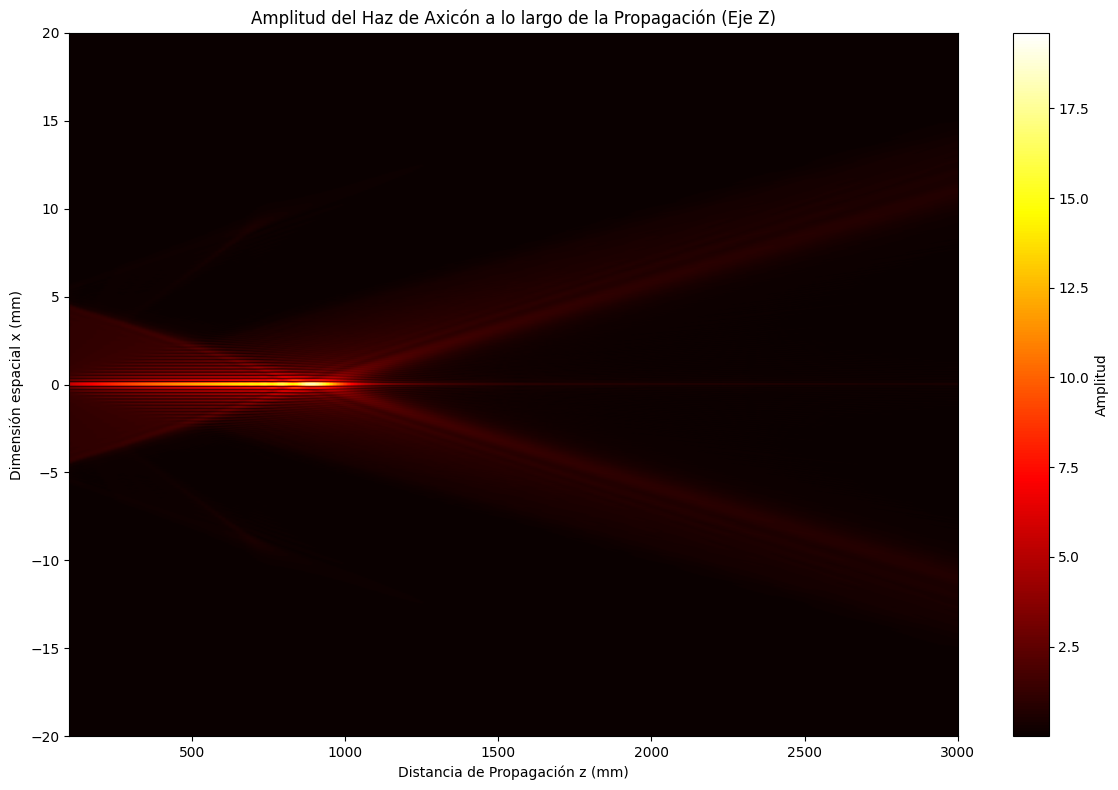

In [16]:
z_values = np.linspace(100, 4e3, 256) # Distancia (mm). Hasta 4000mm
intensity_cross_sections = []
for z_val in z_values:
    # Recalcular sq_arg para H_exacta
    sq_arg_current = (1/lam_0)**2 - (FX**2 + FY**2)

    # Inicializar H_exacta como un array complejo de ceros
    H_exacta_current = np.zeros(sq_arg_current.shape, dtype=complex)

    # Aplicar la máscara de propagación
    mask_prop_current = sq_arg_current >= 0
    H_exacta_current[mask_prop_current] = np.exp(1j * 2 * np.pi * z_val * np.sqrt(sq_arg_current[mask_prop_current]))

    # Propagar el campo
    Uz_current = np.fft.ifft2(U_in_hat * H_exacta_current)

    # Calcular el valor absoluto del campo (Amplitud)
    I_current = np.abs(Uz_current)#**2

    # Extraer la sección transversal central (y=0) y añadirla
    center_idx = N // 2
    intensity_cross_sections.append(I_current[center_idx, :])

# Convertir la lista de secciones transversales de intensidad 1D en un array 2D
# Cada fila corresponde a un valor z diferente, cada columna a una posición x diferente
intensity_heatmap = np.array(intensity_cross_sections)

# Graficar el mapa de calor
plt.figure(figsize=(12, 8))
plt.imshow(
    intensity_heatmap.T,
    extent=[z_values.min(), z_values.max(), -L/2, L/2],
    origin='lower', # Asegura que los valores de x aumenten de abajo hacia arriba
    aspect='auto', # Ajustar la relación de aspecto automáticamente
    cmap='hot' # Mapa de colores
)

plt.title('Amplitud del Haz de Axicón a lo largo de la Propagación (Eje Z)')
plt.xlabel('Distancia de Propagación z (mm)')
plt.ylabel('Dimensión espacial x (mm)')
plt.colorbar(label='Amplitud')
plt.tight_layout()
plt.show()